In [17]:
import pandas as pd
import numpy as np

# 首先导入ground_truth数据
gt = 'gt/1.csv'
GT = pd.read_csv(gt).iloc[:, [2, 3, -1]]

Lat = np.array(GT.iloc[:, 0])
Log = np.array(GT.iloc[:, 1])
Time = np.array(GT.iloc[:, 2])
# print(RefTime.shape)
# 然后导入gnss数据
road = 'gnss/1.csv'
Road = pd.read_csv(road).iloc[:, [1, -3, -2, -1]]
Road = Road.drop_duplicates()

X = np.array(Road.iloc[:, 1])
Y = np.array(Road.iloc[:, 2])
Z = np.array(Road.iloc[:, 3])
RawTime = np.array(Road.iloc[:, 0])
# print(RawTime.shape)

转换为WGS84

In [18]:
a = 6378137.0
b = 6356752.31424518
def ECEF_to_WGS84(x, y, z):
    c = np.sqrt(((a * a) - (b * b)) / (a * a))
    d = np.sqrt(((a * a) - (b * b)) / (b * b))
    p = np.sqrt((x * x) + (y * y))
    q = np.arctan2((z * a), (p * b))
    Longitude = np.arctan2(y, x)
    Latitude = np.arctan2((z + (d * d) * b * np.power(np.sin(q), 3)), (p - (c * c) * a * np.power(np.cos(q), 3)))
    N = a / np.sqrt(1 - ((c * c) * np.power(np.sin(Latitude), 2)))
    Altitude = (p / np.cos(Latitude)) - N
    Longitude = Longitude * 180.0 / np.pi
    Latitude = Latitude * 180.0 / np.pi
    return Latitude, Longitude, Altitude

In [19]:
RawLat, RawLog, RawAlt = ECEF_to_WGS84(X, Y, Z)
del RawAlt

计算地球半径

In [4]:
def R(lat):
    return np.sqrt(
        ((a**2 * np.cos(np.deg2rad(lat)))**2 + (b**2 * np.sin(np.deg2rad(lat)))**2) / ((a * np.cos(np.deg2rad(lat)))**2 + (b * np.sin(np.deg2rad(lat)))**2)
    )

In [20]:
def dis(lon1, lat1, lon2, lat2):
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    ang = np.sin(np.deg2rad(dlat)/2)**2 + np.cos(np.deg2rad(lat1)) * np.cos(np.deg2rad(lat2)) * np.sin(np.deg2rad(dlon/2))**2
    c = 2. * np.arcsin(np.sqrt(ang))
    # r = (R(lat1) + R(lat2)) / 2.
    r = 6367000
    return c * r

In [21]:
ref = 0
error = np.zeros_like(RawLog)
RefTime = np.zeros_like(RawTime)
RefLog = np.zeros_like(RawLog)
RefLat = np.zeros_like(RawLat)

for i in range(RawTime.shape[0]):
    # 找到对应时间戳
    for j in range(ref, Time.shape[0]):
        if abs(RawTime[i] - Time[j]) < 1000:
            ref = j
            RefTime[i] = Time[ref]
            RefLat[i] = Lat[ref]
            RefLog[i] = Log[ref]
            break
del ref, j

for i in range(RawTime.shape[0]):
    # 计算误差
    error[i] = dis(RawLog[i], RawLat[i], RefLog[i], RefLat[i])
print(error)

[ 6.8173967   4.77855341 11.14141308 ...  2.55433891  2.11473144
  2.17000499]


制图

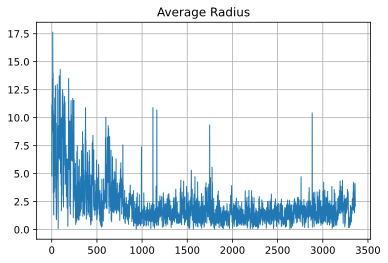

In [22]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='svg'

plt.plot(error, linewidth=1)
plt.grid(True)
plt.title('Average Radius')
plt.show()

In [8]:
print('最大误差:', max(error))
print('平均误差:', sum(error) / error.shape[0])

q50 = np.quantile(error, .50)
q95 = np.quantile(error, .95)
print('score:', (q50 + q95) / 2.)

最大误差: 17.64135828460231
平均误差: 2.2133404821418154
score: 4.25619511012718


如果某一数据点的误差大于1米，就使用三角法

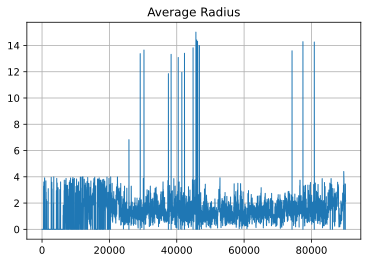

最大误差: 15.016710989177163
平均误差: 1.4303330412439865
score: 2.266799082583097


In [9]:
i = 0

while i < error.shape[0]:
    if i + 1 < error.shape[0]:
        if error[i] > 4:
            RawLat[i] = (RefLat[i] + RefLat[i+1]) / 2.
            RawLog[i] = (RefLog[i] + RefLog[i+1]) / 2.
            error[i] = dis(RawLog[i], RawLat[i], RefLog[i], RefLat[i])
    else:
        if error[i] > 4:
            RawLat[i] = (RefLat[i] + RefLat[i]) / 2.
            RawLog[i] = (RefLog[i] + RefLog[i]) / 2.
            error[i] = dis(RawLog[i], RawLat[i], RefLog[i], RefLat[i])
    i += 1
del i

plt.plot(error, linewidth=1)
plt.grid(True)
plt.title('Average Radius')
plt.show()
print('最大误差:', max(error))
print('平均误差:', sum(error) / error.shape[0])
q50 = np.quantile(error, .50)
q95 = np.quantile(error, .95)
print('score:', (q50 + q95) / 2.)